# Libs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix
from sklearn.inspection import permutation_importance
#from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, chi2

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [3]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 200
pd.set_option('max_colwidth', 1000) # tamanho das colunas para exibição do conteúdo de textos longos
np.set_printoptions(threshold=1000)

# Formatar numeros float (2 casas decimais)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))

In [4]:
random_state=42

# Funcoes

In [5]:
def print_message(msg):
    print(color.BOLD + color.BLUE + '\n' + msg + color.END)
    print(color.BOLD + color.BLUE + 50*'*' + color.END)

In [6]:
def checar_df(df):
    print(color.BOLD  + color.RED + 'Informações do dataframe: ' + color.END)
    df.info(verbose=True, show_counts=True)
    
    print(color.BOLD + color.RED + "\nNúmero de observacoes na base de dados: " + color.END, df.shape[0])
    print('Total de ', df.shape[1], 'Colunas: ', df.columns.values.tolist())
    
    print(color.BOLD + color.RED + "\nNúmero de valores unicos (Não inclui NaN): " + color.END)
    display(df.nunique(dropna=True).to_frame(name='Contagem Unicos').sort_index())
    
    print(color.BOLD + color.RED + "Número de valores nulos:" + color.END)
    display(df.isnull().sum().sort_values(ascending=False).to_frame(name='Contagem Nulos').sort_index())

In [7]:
# passar como parâmetro a lista de colunas para as quais se deseja obter os valores únicos existentes
def checar_val_colunas_df_lista(df, lista_colunas):
    print(color.BOLD + color.RED + "Contagem de valores unicos (inclui NaN) e apresentação da lista de valores:  \n"  
      + color.END)
    for column in lista_colunas:
        print(column, ': ', len(df[column].unique()),'valores únicos \n',
              df[column].sort_values().unique().tolist(), '\n')

In [8]:
# passar como parâmetro o número máximo de valores únicos (n_unique)
# Ex. mostrar colunas e seus valores únicos apenas quando a coluna tem acima de N valores únicos
def checar_val_colunas_df_nunique(df, n_unique):
    df_count_unique = df.nunique(dropna=True).to_frame(name='Contagem Unicos').sort_values(by='Contagem Unicos')
    lista_colunas = df_count_unique[df_count_unique['Contagem Unicos'] >= n_unique].index
    
    print(color.BOLD + color.RED + "Contagem de valores unicos (inclui NaN) e apresentação da lista de valores: "  
      + color.END)
    print(color.BOLD + color.RED + '(acima de', n_unique, 'valores únicos)\n' + color.END)
    for column in lista_colunas:
        print(column, ': ', len(df[column].unique()),'valores únicos \n',
              df[column].sort_values().unique().tolist(), '\n')

In [9]:
def create_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    # Plotar a matriz de confusão
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['PBZ', 'BR', 'ASM'],  
            yticklabels=['PBZ', 'BR', 'ASM'])  
    plt.title('Matriz de Confusão')
    plt.xlabel('Prevista')
    plt.ylabel('Real')
    plt.show()

In [10]:
# Função para calcular e armazenar a importância para um modelo
def calcular_importancia(model, X_test, y_test, model_name):
    #global feature_importance_df
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, 
                                             random_state=random_state, 
                                             n_jobs=-1)  
    importance_vals = perm_importance.importances_mean
    importance_std = perm_importance.importances_std
    feature_importance_temp = pd.DataFrame({
        'Feature': X_test.columns,
        'Importância': importance_vals,
        'Desvio_Padrao': importance_std,
        'Modelo': model_name})
    return feature_importance_temp

In [11]:
def plotar_feature_importance(df, nome_modelo):

    dados = df[df['Modelo']==nome_modelo]
    dados = dados.sort_values(by='Importância', ascending=False)

    plt.figure(figsize=(8, 4))
    plt.barh(dados['Feature'], 
             dados['Importância'], 
             xerr=dados['Desvio_Padrao'], 
             color='skyblue')
    titulo = f'Importância das Features por Permutação - {nome_modelo} (Features com Importância > 0)'
    plt.title(titulo, fontsize=10)
    plt.xlabel('Importância'); plt.xticks(fontsize=8)
    plt.ylabel(''); plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.show()   

# Carga dados

## Carga arquivo

In [12]:
%%time
df_fam = pd.read_csv('../Data/df_familia_final.csv',
                     sep=',', 
                     low_memory=False)

# remover colunas irrelevantes
del df_fam['peso.fam']

CPU times: total: 78.1 ms
Wall time: 165 ms


In [13]:
# checagem básica
distintos = df_fam['id_familia'].nunique()
print(f'Qtd de familias: {distintos}')

duplicados = df_fam['id_familia'].duplicated().sum()
print(f'Duplicados na coluna id_familia: {duplicados}')

Qtd de familias: 96502
Duplicados na coluna id_familia: 0


## Converter dados

In [14]:
l_col_int = [col for col in df_fam.columns if col.startswith('cod') 
                 or col.startswith('qtd') 
                 or col.startswith('dias')
                 or col.startswith('ind')]  
l_col_int = l_col_int + ['estrato','classf', 'classe_renda']

#print_message('Colunas do tipo int'); display(l_col_int)

for c in l_col_int:
    df_fam[c] = df_fam[c].astype(int)

In [15]:
df_fam.columns

Index(['cd_ibge', 'uf_ibge', 'regiao_ibge', 'estrato', 'classf', 'id_familia',
       'vlr_renda_media_fam', 'cod_local_domic_fam', 'cod_especie_domic_fam',
       'qtd_comodos_domic_fam', 'qtd_comodos_dormitorio_fam',
       'cod_material_piso_fam', 'cod_material_domic_fam',
       'cod_agua_canalizada_fam', 'cod_abaste_agua_domic_fam',
       'cod_banheiro_domic_fam', 'cod_escoa_sanitario_domic_fam',
       'cod_destino_lixo_domic_fam', 'cod_iluminacao_domic_fam',
       'cod_calcamento_domic_fam', 'cod_familia_indigena_fam',
       'ind_familia_quilombola_fam', 'ind_parc_mds_fam', 'qtde_pessoas',
       'dias_cadastramento', 'dias_atualizacao', 'classe_renda'],
      dtype='object')

In [16]:
col_interesse = list(df_fam.columns.values)

cols = ['cd_ibge','id_familia', 'vlr_renda_media_fam', 'dias_cadastramento', 'dias_atualizacao']
for c in cols:
    col_interesse.remove(c)

checar_val_colunas_df_lista(df_fam, col_interesse)

Contagem de valores unicos (inclui NaN) e apresentação da lista de valores:  

uf_ibge :  27 valores únicos 
 [11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 35, 41, 42, 43, 50, 51, 52, 53] 

regiao_ibge :  5 valores únicos 
 [1, 2, 3, 4, 5] 

estrato :  2 valores únicos 
 [1, 2] 

classf :  3 valores únicos 
 [1, 2, 3] 

cod_local_domic_fam :  3 valores únicos 
 [1, 2, 9] 

cod_especie_domic_fam :  4 valores únicos 
 [1, 2, 3, 9] 

qtd_comodos_domic_fam :  18 valores únicos 
 [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] 

qtd_comodos_dormitorio_fam :  16 valores únicos 
 [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20] 

cod_material_piso_fam :  8 valores únicos 
 [-1, 1, 2, 3, 4, 5, 6, 7] 

cod_material_domic_fam :  9 valores únicos 
 [-1, 1, 2, 3, 4, 5, 6, 7, 8] 

cod_agua_canalizada_fam :  3 valores únicos 
 [-1, 1, 2] 

cod_abaste_agua_domic_fam :  5 valores únicos 
 [-1, 1, 2, 3, 4] 

cod_banheiro_domic_fam :  3 valores únicos 

# Identificar variáveis de alta multicolinearidade

## Matriz correlação

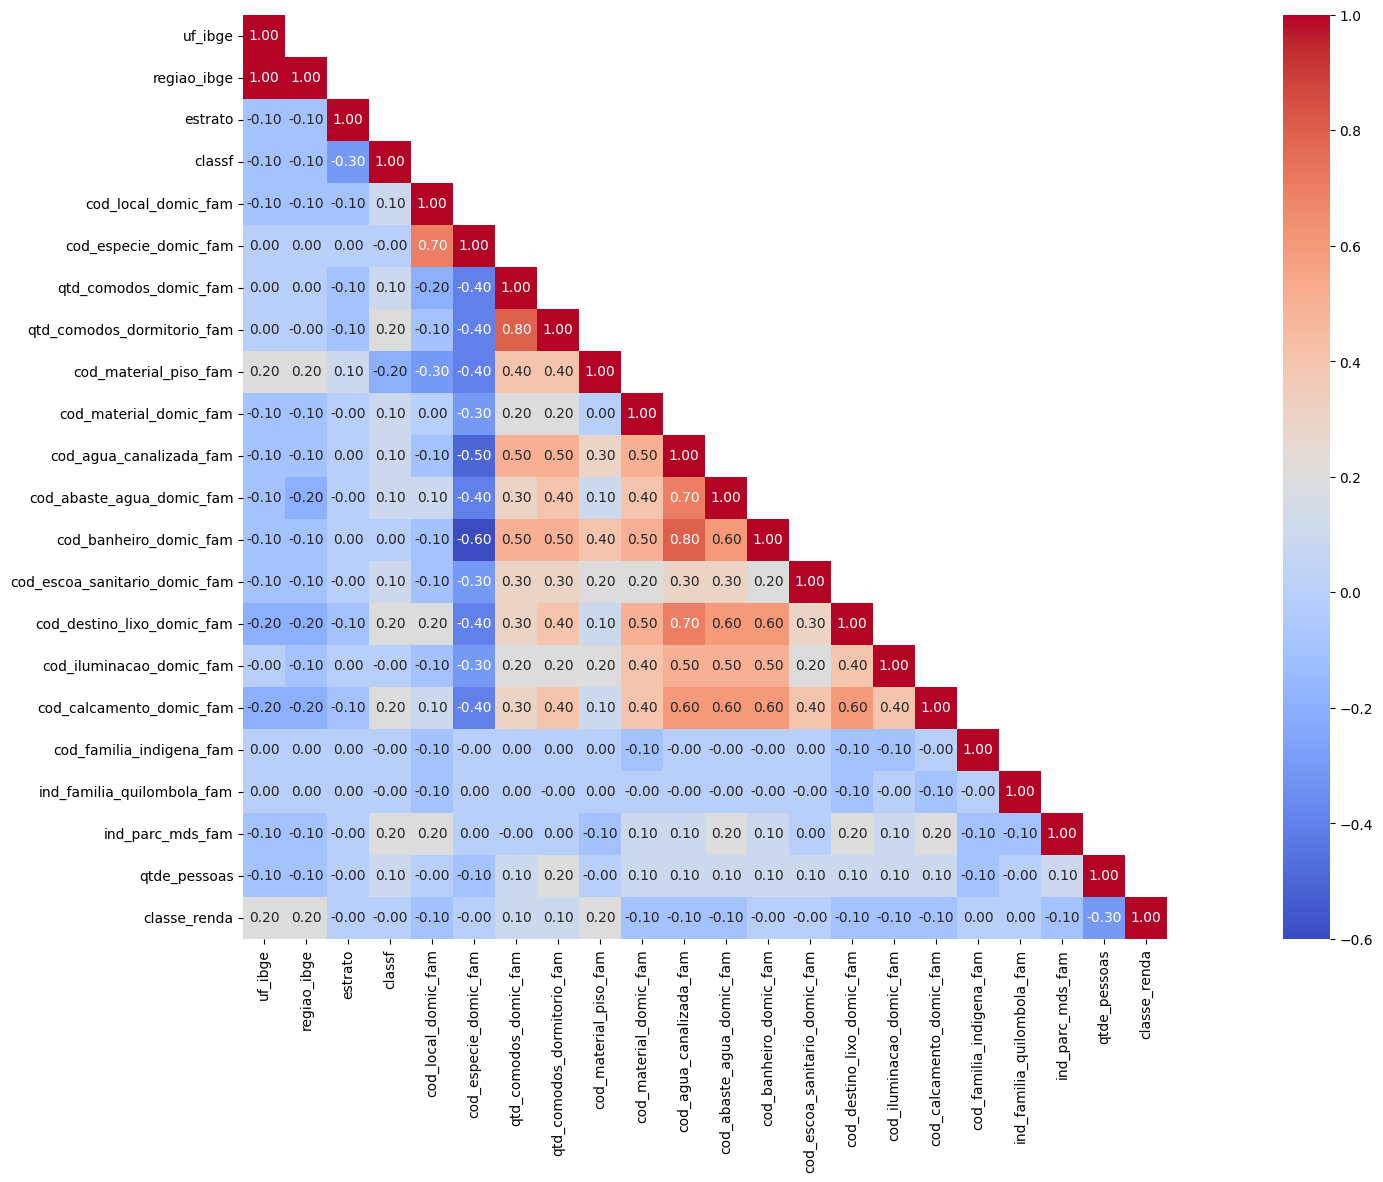

In [17]:
df_features = df_fam[col_interesse]

mask = np.triu(np.ones_like(df_features.corr(), dtype=bool), k=1)
plt.figure(figsize=(30,12))
sns.heatmap(df_features.corr().round(1), 
            annot=True, 
            square=True, 
            fmt='.2f',
            annot_kws={'size': 10},
            cmap='coolwarm', 
            mask=mask)
plt.show()

In [18]:
# Obter os valores de correlação acima de um certo valor
# exceto valores da diagonal principal
corr_matrix = df_features.corr().abs()
threshold = 0.7
high_corr_pairs = np.where((corr_matrix > threshold) 
                           & (np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)))

# Obter os pares de colunas com correlação > threshold
high_corr_list = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y]) 
                  for x, y in zip(*high_corr_pairs)]

for col1, col2, corr_value in high_corr_list:
    print(f"Colunas: {col1} e {col2}, Correlação: {corr_value:.2f}")

Colunas: uf_ibge e regiao_ibge, Correlação: 0.97
Colunas: cod_local_domic_fam e cod_especie_domic_fam, Correlação: 0.73
Colunas: qtd_comodos_domic_fam e qtd_comodos_dormitorio_fam, Correlação: 0.81
Colunas: cod_agua_canalizada_fam e cod_abaste_agua_domic_fam, Correlação: 0.74
Colunas: cod_agua_canalizada_fam e cod_banheiro_domic_fam, Correlação: 0.83


## Excluir colunas de alta correlação

In [19]:
col_high_corr = ['regiao_ibge', 'qtd_comodos_dormitorio_fam','cod_banheiro_domic_fam']
for c in col_high_corr:
    del df_fam[c]

In [20]:
df_fam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96502 entries, 0 to 96501
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cd_ibge                        96502 non-null  int64  
 1   uf_ibge                        96502 non-null  int64  
 2   estrato                        96502 non-null  int32  
 3   classf                         96502 non-null  int32  
 4   id_familia                     96502 non-null  int64  
 5   vlr_renda_media_fam            96502 non-null  float64
 6   cod_local_domic_fam            96502 non-null  int32  
 7   cod_especie_domic_fam          96502 non-null  int32  
 8   qtd_comodos_domic_fam          96502 non-null  int32  
 9   cod_material_piso_fam          96502 non-null  int32  
 10  cod_material_domic_fam         96502 non-null  int32  
 11  cod_agua_canalizada_fam        96502 non-null  int32  
 12  cod_abaste_agua_domic_fam      96502 non-null 

# Normalização

In [21]:
#df_fam_bkp = df_fam.copy()

In [22]:
df_fam.columns

Index(['cd_ibge', 'uf_ibge', 'estrato', 'classf', 'id_familia',
       'vlr_renda_media_fam', 'cod_local_domic_fam', 'cod_especie_domic_fam',
       'qtd_comodos_domic_fam', 'cod_material_piso_fam',
       'cod_material_domic_fam', 'cod_agua_canalizada_fam',
       'cod_abaste_agua_domic_fam', 'cod_escoa_sanitario_domic_fam',
       'cod_destino_lixo_domic_fam', 'cod_iluminacao_domic_fam',
       'cod_calcamento_domic_fam', 'cod_familia_indigena_fam',
       'ind_familia_quilombola_fam', 'ind_parc_mds_fam', 'qtde_pessoas',
       'dias_cadastramento', 'dias_atualizacao', 'classe_renda'],
      dtype='object')

In [23]:
# 'classe_renda'
# 'cd_ibge', 'id_familia', 'vlr_renda_media_fam',
col_norm = ['uf_ibge',  'estrato', 'classf', 
        'cod_local_domic_fam', 'cod_especie_domic_fam',
       'qtd_comodos_domic_fam', 
       'cod_material_piso_fam', 'cod_material_domic_fam',
       'cod_agua_canalizada_fam', 'cod_abaste_agua_domic_fam',
       'cod_escoa_sanitario_domic_fam',
       'cod_destino_lixo_domic_fam', 'cod_iluminacao_domic_fam',
       'cod_calcamento_domic_fam', 'cod_familia_indigena_fam',
       'ind_familia_quilombola_fam', 'ind_parc_mds_fam', 'qtde_pessoas',
       'dias_cadastramento', 'dias_atualizacao']

# Normalizar as variáveis categóricas numéricas
scaler = MinMaxScaler()
df_fam[col_norm] = scaler.fit_transform(df_fam[col_norm])

# Verificar os valores normalizados
df_fam.head()

,cd_ibge,uf_ibge,estrato,classf,id_familia,vlr_renda_media_fam,cod_local_domic_fam,cod_especie_domic_fam,qtd_comodos_domic_fam,cod_material_piso_fam,cod_material_domic_fam,cod_agua_canalizada_fam,cod_abaste_agua_domic_fam,cod_escoa_sanitario_domic_fam,cod_destino_lixo_domic_fam,cod_iluminacao_domic_fam,cod_calcamento_domic_fam,cod_familia_indigena_fam,ind_familia_quilombola_fam,ind_parc_mds_fam,qtde_pessoas,dias_cadastramento,dias_atualizacao,classe_renda
0,4212908,0.7381,0.0000,0.5000,268503,60.0000,0.0000,0.0000,0.3529,0.7500,0.2222,0.6667,0.4000,0.5714,0.2857,0.2857,0.5000,1.0000,1.0000,0.0000,0.2500,0.7980,0.0571,0
1,2931905,0.4286,1.0000,1.0000,2888440,0.0000,0.1250,0.0000,0.1765,0.3750,0.3333,1.0000,1.0000,0.5714,0.5714,0.2857,1.0000,1.0000,1.0000,0.0000,0.0833,0.4105,0.0901,0
2,3527207,0.5714,1.0000,1.0000,2113517,713.0000,0.0000,0.0000,0.3529,0.7500,0.2222,0.6667,0.4000,0.2857,0.2857,0.2857,0.5000,1.0000,1.0000,0.0000,0.0833,0.9308,0.3125,2
3,3303500,0.5238,1.0000,0.5000,4419096,50.0000,0.0000,0.0000,0.2353,0.7500,0.2222,0.6667,0.4000,0.2857,0.2857,0.2857,0.5000,1.0000,1.0000,0.0000,0.0833,0.0345,0.1485,0
4,2800308,0.4048,1.0000,0.0000,4241219,90.0000,0.0000,0.0000,0.2941,0.7500,0.3333,0.6667,0.4000,0.2857,0.2857,0.2857,0.5000,1.0000,1.0000,0.0000,0.0000,0.8560,0.0000,0


# Seleção variáveis independentes

In [24]:
df_fam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96502 entries, 0 to 96501
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cd_ibge                        96502 non-null  int64  
 1   uf_ibge                        96502 non-null  float64
 2   estrato                        96502 non-null  float64
 3   classf                         96502 non-null  float64
 4   id_familia                     96502 non-null  int64  
 5   vlr_renda_media_fam            96502 non-null  float64
 6   cod_local_domic_fam            96502 non-null  float64
 7   cod_especie_domic_fam          96502 non-null  float64
 8   qtd_comodos_domic_fam          96502 non-null  float64
 9   cod_material_piso_fam          96502 non-null  float64
 10  cod_material_domic_fam         96502 non-null  float64
 11  cod_agua_canalizada_fam        96502 non-null  float64
 12  cod_abaste_agua_domic_fam      96502 non-null 

## Definir conjuntos preditoras e target

In [25]:
# excluir 'cd_ibge', 'id_familia', 'vlr_renda_media_fam', 'classe_renda'
var_indep = ['uf_ibge', 'estrato', 'classf', 
       'cod_local_domic_fam', 'cod_especie_domic_fam',
       'qtd_comodos_domic_fam', 'cod_material_piso_fam',
       'cod_material_domic_fam', 'cod_agua_canalizada_fam',
       'cod_abaste_agua_domic_fam', 'cod_escoa_sanitario_domic_fam',
       'cod_destino_lixo_domic_fam', 'cod_iluminacao_domic_fam',
       'cod_calcamento_domic_fam', 'cod_familia_indigena_fam',
       'ind_familia_quilombola_fam', 'ind_parc_mds_fam', 'qtde_pessoas',
       'dias_cadastramento', 'dias_atualizacao']

In [26]:
X = df_fam[var_indep]
y = df_fam['classe_renda']

## Verificações

In [27]:
print('Shape do df:', X.shape)
print('Tipos existentes no dataframe X:', X.dtypes.unique())

Shape do df: (96502, 20)
Tipos existentes no dataframe X: [dtype('float64')]


In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96502 entries, 0 to 96501
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   uf_ibge                        96502 non-null  float64
 1   estrato                        96502 non-null  float64
 2   classf                         96502 non-null  float64
 3   cod_local_domic_fam            96502 non-null  float64
 4   cod_especie_domic_fam          96502 non-null  float64
 5   qtd_comodos_domic_fam          96502 non-null  float64
 6   cod_material_piso_fam          96502 non-null  float64
 7   cod_material_domic_fam         96502 non-null  float64
 8   cod_agua_canalizada_fam        96502 non-null  float64
 9   cod_abaste_agua_domic_fam      96502 non-null  float64
 10  cod_escoa_sanitario_domic_fam  96502 non-null  float64
 11  cod_destino_lixo_domic_fam     96502 non-null  float64
 12  cod_iluminacao_domic_fam       96502 non-null 

In [29]:
X.isnull().sum()

uf_ibge                          0
estrato                          0
classf                           0
cod_local_domic_fam              0
cod_especie_domic_fam            0
qtd_comodos_domic_fam            0
cod_material_piso_fam            0
cod_material_domic_fam           0
cod_agua_canalizada_fam          0
cod_abaste_agua_domic_fam        0
cod_escoa_sanitario_domic_fam    0
cod_destino_lixo_domic_fam       0
cod_iluminacao_domic_fam         0
cod_calcamento_domic_fam         0
cod_familia_indigena_fam         0
ind_familia_quilombola_fam       0
ind_parc_mds_fam                 0
qtde_pessoas                     0
dias_cadastramento               0
dias_atualizacao                 0
dtype: int64

# Teste Chi2

In [30]:
# FEATURE SELECTION - MÉTODO CHI-QUADRADO

# Selecionando duas variáveis com maior chi-quadrado
chi2_selector = SelectKBest(chi2, k='all') # MÉTODO CHI-QUADRADO
X_kbest = chi2_selector.fit_transform(X, y)

# Obtendo os scores e os nomes das variáveis
scores = chi2_selector.scores_
selected_features = X.columns[chi2_selector.get_support()]

# Criando um DataFrame com os nomes das variáveis e seus scores
features_scores_df = pd.DataFrame({
    'Feature': X.columns,
    'Score': scores})

# Filtrando apenas as variáveis selecionadas
features_scores_df = features_scores_df[features_scores_df['Feature'].isin(selected_features)]

# Ordenando o DataFrame pelos scores em ordem decrescente
features_scores_df = features_scores_df.sort_values(by='Score', ascending=False)

features_scores_df

,Feature,Score
17,qtde_pessoas,1378.5093
18,dias_cadastramento,1370.6036
16,ind_parc_mds_fam,814.1209
6,cod_material_piso_fam,363.5054
3,cod_local_domic_fam,344.9830
0,uf_ibge,324.9928
13,cod_calcamento_domic_fam,171.9324
4,cod_especie_domic_fam,160.1490
5,qtd_comodos_domic_fam,82.3997
19,dias_atualizacao,68.7151


# Geração modelos

## Divisão dados treino e testes

In [31]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

## Definir pipeline de modelos

In [32]:
# Definir os modelos e os parâmetros
models = {
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=random_state),
        'param_grid': {
            'classifier__max_depth': [3, 5, 7],
            'classifier__min_samples_split': [2, 5, 10] }},
    
    'RandomForest': {
        'model': RandomForestClassifier(random_state=random_state),
        'param_grid': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 10, 20] }},
    
    'XGBoost': {
        'model': XGBClassifier(objective='multi:softmax', 
                               num_class=3, 
                               random_state=random_state),
        'param_grid': {
            'classifier__n_estimators': [250, 300],
            'classifier__max_depth': [3, 5],
            'classifier__learning_rate': [0.1] }},
    
    'CatBoost': {
        'model': CatBoostClassifier(silent=True, random_state=random_state),
        'param_grid': {
            'classifier__iterations': [250, 500],
            'classifier__depth': [3, 5],
            'classifier__learning_rate': [0.1]
        }}}

## Selecionar melhores modelos

In [33]:
# Criar um dicionário para armazenar os melhores modelos
best_models = {}

for model_name, model_info in models.items():
    # Criar o pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model_info['model'])
    ])
    
    # Definir GridSearchCV
    grid_search = GridSearchCV(pipeline, 
                               model_info['param_grid'], 
                               cv=3, scoring='f1_macro', 
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Armazenar o melhor modelo
    best_models[model_name] = grid_search.best_estimator_
    print(f"Melhores hiperparâmetros para {model_name}: {grid_search.best_params_}")

Melhores hiperparâmetros para DecisionTree: {'classifier__max_depth': 7, 'classifier__min_samples_split': 5}
Melhores hiperparâmetros para RandomForest: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
Melhores hiperparâmetros para XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 300}


C:\Users\Admin\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\miniconda3\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\miniconda3\Lib\site-packages\imblearn\pipeline.py", line 333, in fit
    self._final_estimator.

Melhores hiperparâmetros para CatBoost: {'classifier__depth': 5, 'classifier__iterations': 500, 'classifier__learning_rate': 0.1}


## Avaliar modelos

In [34]:
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    
    # Calcular F1 Score
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Calcular Acurácia
    accuracy = accuracy_score(y_test, y_pred)
    
    # Exibir os resultados
    print(f"\nModelo: {model_name}")
    print(f"  F1 Score: {f1:.2f}")
    print(f"  Acurácia: {accuracy:.2f}")


Modelo: DecisionTree
  F1 Score: 0.48
  Acurácia: 0.64

Modelo: RandomForest
  F1 Score: 0.53
  Acurácia: 0.65

Modelo: XGBoost
  F1 Score: 0.54
  Acurácia: 0.66

Modelo: CatBoost
  F1 Score: 0.54
  Acurácia: 0.67


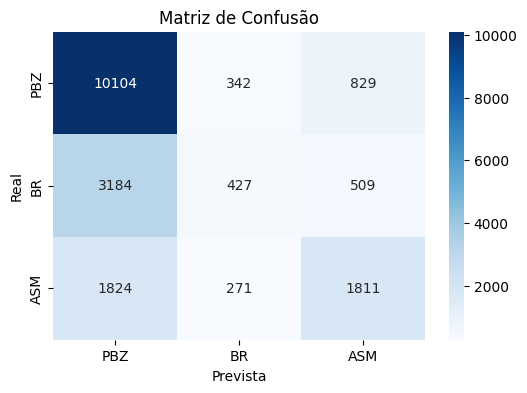

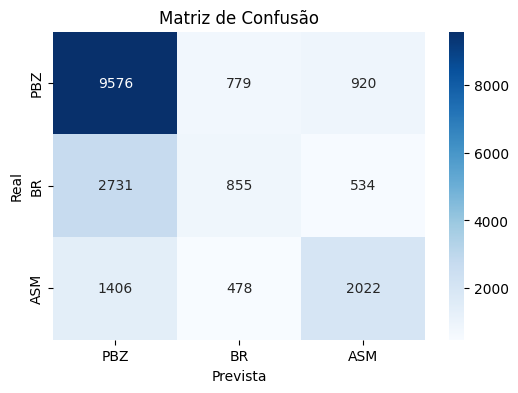

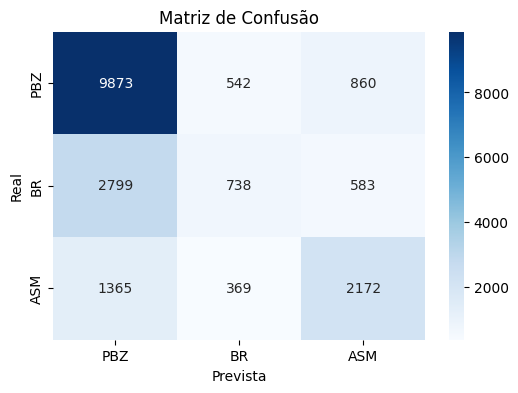

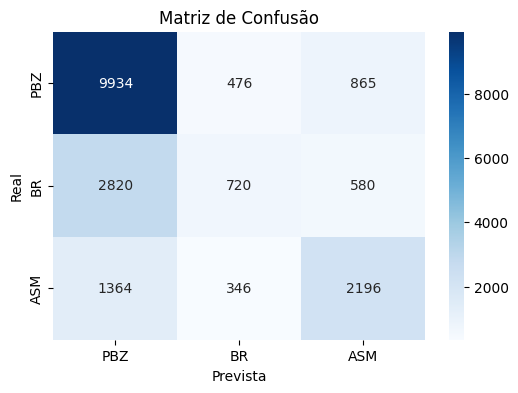

In [35]:
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    create_confusion_matrix(y_test, y_pred)

# Analise importancia features

In [36]:
feature_importance_df = pd.DataFrame()

In [37]:
%%time
# Calcular importâncias para cada modelo
all_importances = []
all_importances.append(calcular_importancia(best_models['DecisionTree'], X_test, y_test, 'DecisionTree'))
all_importances.append(calcular_importancia(best_models['RandomForest'], X_test, y_test, 'RandomForest'))
all_importances.append(calcular_importancia(best_models['XGBoost'], X_test, y_test, 'XGBoost'))
all_importances.append(calcular_importancia(best_models['CatBoost'], X_test, y_test, 'CatBoost'))

# Concatenar todos os resultados 
feature_importance_df = pd.concat(all_importances, ignore_index=True)
feature_importance_df = feature_importance_df[feature_importance_df['Importância'] > 0.0]

modelos = list(feature_importance_df['Modelo'].unique())

CPU times: total: 9.61 s
Wall time: 1min 50s


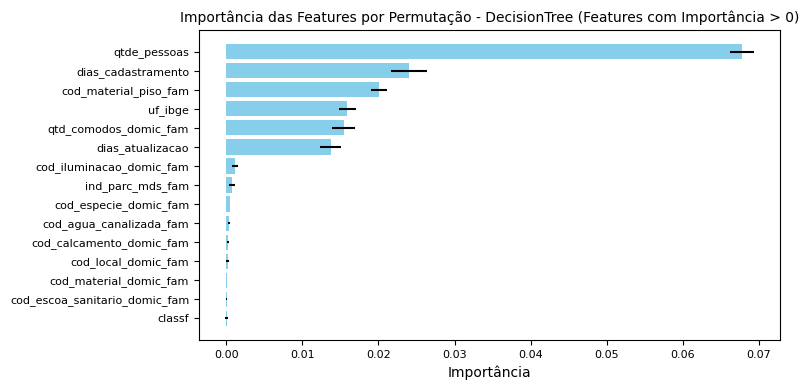

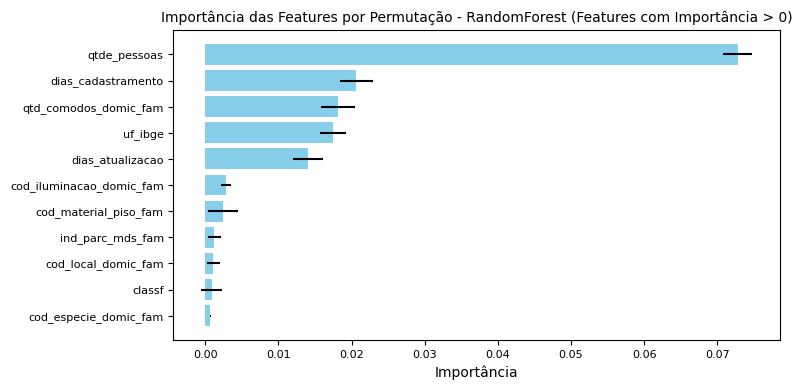

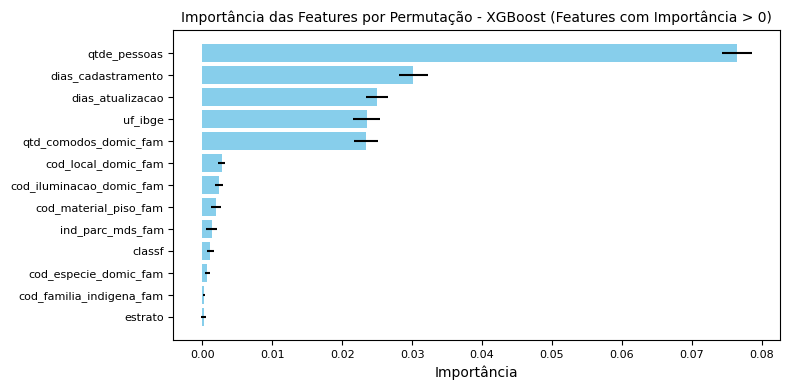

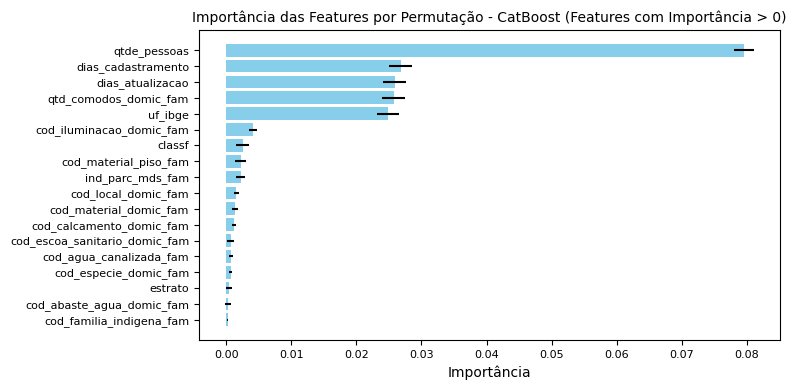

In [38]:
for m in modelos:
    plotar_feature_importance(feature_importance_df, m)

In [39]:
top_10_features_per_model = {}

for model_name in feature_importance_df['Modelo'].unique():
    model_group = feature_importance_df[feature_importance_df['Modelo'] == model_name]
    model_group = model_group.sort_values(by='Importância', ascending=False).head(10)
    top_10_features_per_model[model_name] = model_group[['Feature', 'Importância']]

for model_name, top_features in top_10_features_per_model.items():
    print(f"\nTop 10 Features para o modelo {model_name}:")
    print(50*'-')
    print(top_features.to_string(index=False))


Top 10 Features para o modelo DecisionTree:
--------------------------------------------------
                 Feature  Importância
            qtde_pessoas       0.0678
      dias_cadastramento       0.0240
   cod_material_piso_fam       0.0200
                 uf_ibge       0.0159
   qtd_comodos_domic_fam       0.0154
        dias_atualizacao       0.0137
cod_iluminacao_domic_fam       0.0011
        ind_parc_mds_fam       0.0008
   cod_especie_domic_fam       0.0004
 cod_agua_canalizada_fam       0.0003

Top 10 Features para o modelo RandomForest:
--------------------------------------------------
                 Feature  Importância
            qtde_pessoas       0.0728
      dias_cadastramento       0.0207
   qtd_comodos_domic_fam       0.0182
                 uf_ibge       0.0174
        dias_atualizacao       0.0140
cod_iluminacao_domic_fam       0.0028
   cod_material_piso_fam       0.0024
        ind_parc_mds_fam       0.0012
     cod_local_domic_fam       0.0011
          

# Balanceamento

## Informações

In [40]:
target_distribution = y.value_counts(normalize=True)
print("Distribuição da variável target 'classe_renda':")
target_distribution

Distribuição da variável target 'classe_renda':


classe_renda
0   0.5842
1   0.2134
2   0.2024
Name: proportion, dtype: float64

In [41]:
absolute_distribution = y.value_counts()
print("Número absoluto de ocorrências por classe:")
absolute_distribution

Número absoluto de ocorrências por classe:


classe_renda
0    56373
1    20597
2    19532
Name: count, dtype: int64

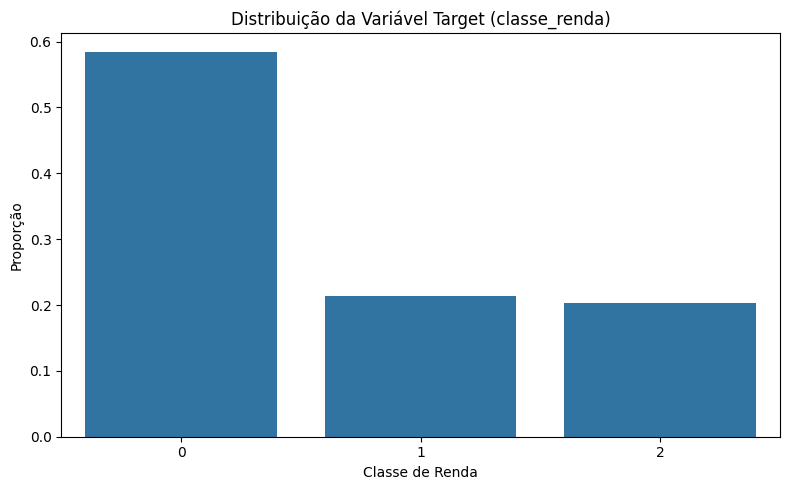

In [42]:
plt.figure(figsize=(8, 5))
sns.barplot(x=target_distribution.index, y=target_distribution.values)
plt.title('Distribuição da Variável Target (classe_renda)')
plt.xlabel('Classe de Renda'); plt.ylabel('Proporção'); plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Balanceando as classes

In [43]:
# Primeiro, aplica-se o SMOTE para criar amostras sintéticas das classes minoritárias
# Depois, faz-se undersampling para reduzir a classe majoritária a um tamanho mais equilibrado
over = SMOTE(sampling_strategy={1.0: 35000, 2.0: 35000})  # Aumenta as classes 1 e 2 para 35k cada
under = RandomUnderSampler(sampling_strategy={0.0: 40000})  # Reduz a classe 0 para 40k

In [44]:
# Criar um pipeline que aplica SMOTE e depois o undersampling
pipeline = Pipeline(steps=[('o', over), ('u', under)])

In [45]:
# Aplicar o balanceamento ao conjunto de dados
X_balanced, y_balanced = pipeline.fit_resample(X, y)

In [46]:
# Verificar a nova distribuição das classes
balanced_distribution = pd.Series(y_balanced).value_counts()

print("Distribuição da variável target 'classe_renda' após o balanceamento:")
print(balanced_distribution)

Distribuição da variável target 'classe_renda' após o balanceamento:
classe_renda
0    40000
1    35000
2    35000
Name: count, dtype: int64


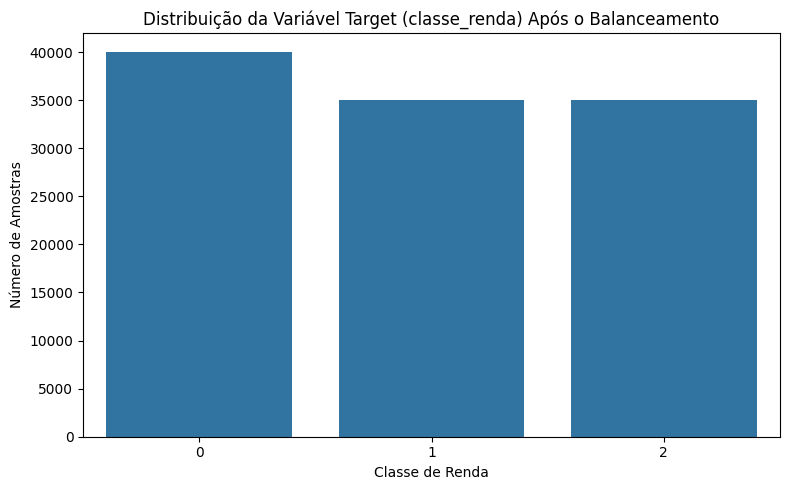

In [47]:
plt.figure(figsize=(8, 5))
sns.barplot(x=balanced_distribution.index, y=balanced_distribution.values)
plt.title('Distribuição da Variável Target (classe_renda) Após o Balanceamento')
plt.xlabel('Classe de Renda')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [48]:
print(X_balanced.shape)
print(y_balanced.shape)

(110000, 20)
(110000,)


## Dividir os dados em treino e teste após balanceamento

In [49]:
X_balanced_train, X_balanced_test, y_balanced_train, y_balanced_test = train_test_split(X_balanced, 
                                                                                        y_balanced, 
                                                                                        test_size=0.2, 
                                                                                        random_state=random_state)

## Definir pipeline de modelos

In [50]:
# Definir os modelos e os parâmetros
models_balanced  = {
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=random_state),
        'param_grid': {
            'classifier__max_depth': [3, 5, 7],
            'classifier__min_samples_split': [2, 5, 10] }},
    
    'RandomForest': {
        'model': RandomForestClassifier(random_state=random_state),
        'param_grid': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 10, 20] }},
    
    'XGBoost': {
        'model': XGBClassifier(objective='multi:softmax', 
                               num_class=3, 
                               random_state=random_state),
        'param_grid': {
            'classifier__n_estimators': [250, 300],
            'classifier__max_depth': [3, 5],
            'classifier__learning_rate': [0.1] }},
    
    'CatBoost': {
        'model': CatBoostClassifier(silent=True, random_state=random_state),
        'param_grid': {
            'classifier__iterations': [250, 500],
            'classifier__depth': [3, 5],
            'classifier__learning_rate': [0.1]
        }}}

## Selecionar melhores modelos

In [51]:
%%time

# Criar um dicionário para armazenar os melhores modelos
best_models_balanced = {}

for model_name, model_info in models_balanced.items():
    # Criar o pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model_info['model'])])
    
    # Definir GridSearchCV
    grid_search = GridSearchCV(pipeline, 
                               model_info['param_grid'], 
                               cv=3, scoring='f1_macro', 
                               n_jobs=-1)
    grid_search.fit(X_balanced_train, y_balanced_train)
    
    # Armazenar o melhor modelo
    best_models_balanced[model_name] = grid_search.best_estimator_
    print(f"Melhores hiperparâmetros para {model_name} (usando dados balanceados): {grid_search.best_params_}")

Melhores hiperparâmetros para DecisionTree (usando dados balanceados): {'classifier__max_depth': 7, 'classifier__min_samples_split': 5}
Melhores hiperparâmetros para RandomForest (usando dados balanceados): {'classifier__max_depth': None, 'classifier__n_estimators': 200}
Melhores hiperparâmetros para XGBoost (usando dados balanceados): {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 300}
Melhores hiperparâmetros para CatBoost (usando dados balanceados): {'classifier__depth': 5, 'classifier__iterations': 500, 'classifier__learning_rate': 0.1}
CPU times: total: 38.3 s
Wall time: 2min 7s


## Avaliar modelos

In [52]:
# Avaliar todos os modelos usando dados balanceados
for model_name, model in best_models_balanced.items():
    y_pred = model.predict(X_balanced_test)  

    f1 = f1_score(y_balanced_test, y_pred, average='macro')
    accuracy = accuracy_score(y_balanced_test, y_pred)

    # Exibir os resultados
    print(f"\nModelo (usando dados balanceados): {model_name}")
    print(f"  F1 Score: {f1:.2f}")
    print(f"  Acurácia: {accuracy:.2f}")


Modelo (usando dados balanceados): DecisionTree
  F1 Score: 0.59
  Acurácia: 0.60

Modelo (usando dados balanceados): RandomForest
  F1 Score: 0.68
  Acurácia: 0.69

Modelo (usando dados balanceados): XGBoost
  F1 Score: 0.66
  Acurácia: 0.67

Modelo (usando dados balanceados): CatBoost
  F1 Score: 0.66
  Acurácia: 0.67


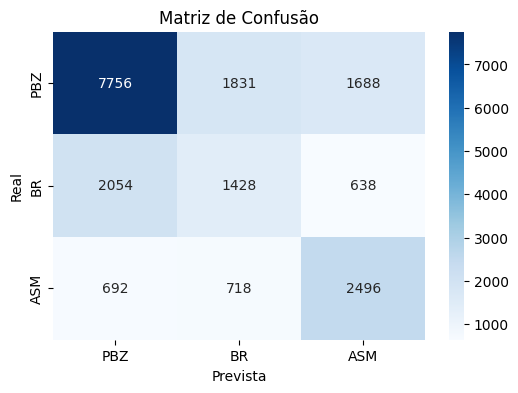

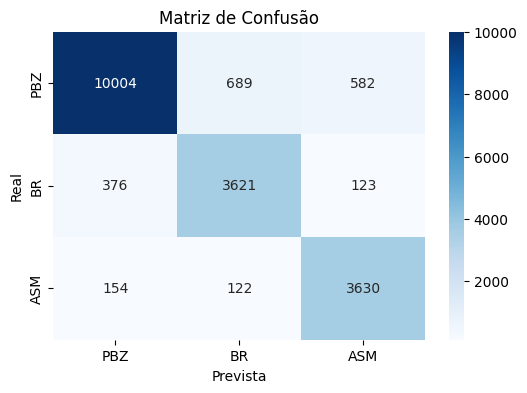

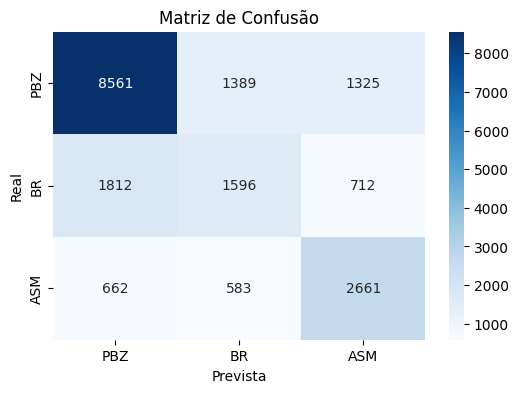

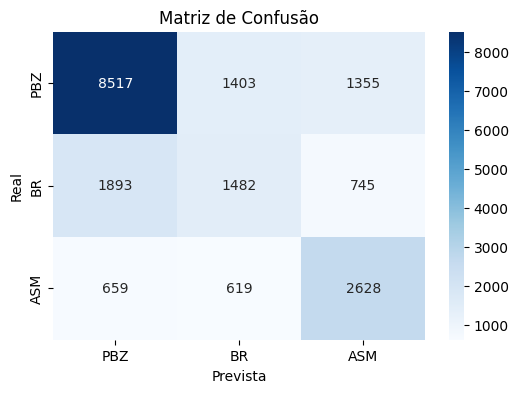

In [53]:
for model_name, model in best_models_balanced.items():
    y_pred = model.predict(X_test)
    create_confusion_matrix(y_test, y_pred)

# Analise importancia features

In [54]:
feature_importance_df_balanced  = pd.DataFrame()

In [55]:
%%time
# Calcular importâncias para cada modelo
all_importances = []
all_importances.append(calcular_importancia(best_models['DecisionTree'], X_balanced_test, y_balanced_test, 'DecisionTree'))
all_importances.append(calcular_importancia(best_models['RandomForest'], X_balanced_test, y_balanced_test, 'RandomForest'))
all_importances.append(calcular_importancia(best_models['XGBoost'], X_balanced_test, y_balanced_test, 'XGBoost'))
all_importances.append(calcular_importancia(best_models['CatBoost'], X_balanced_test, y_balanced_test, 'CatBoost'))

# Concatenar todos os resultados 
feature_importance_df_balanced = pd.concat(all_importances, ignore_index=True)
feature_importance_df_balanced = feature_importance_df_balanced[feature_importance_df_balanced['Importância'] > 0.0]

modelos = list(feature_importance_df_balanced['Modelo'].unique())

CPU times: total: 11.4 s
Wall time: 1min 17s


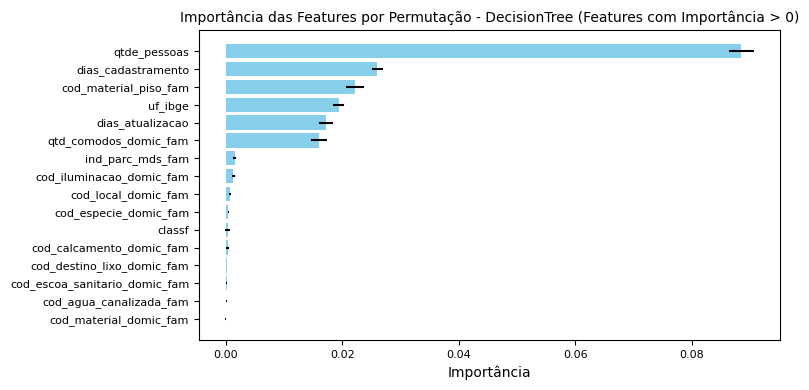

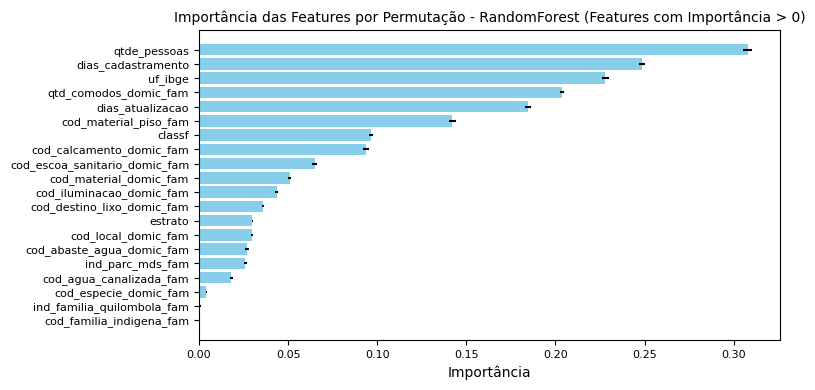

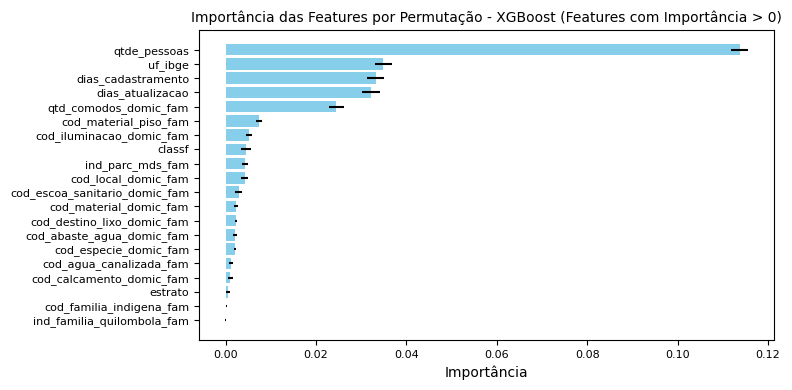

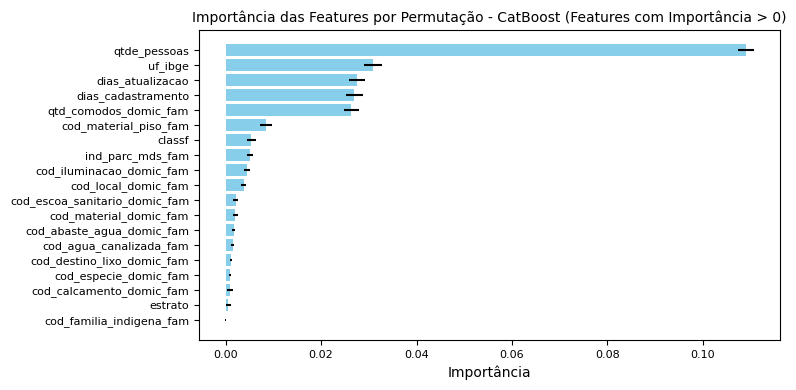

In [56]:
for m in modelos:
    plotar_feature_importance(feature_importance_df_balanced, m)

In [57]:
top_10_features_per_model_b = {}

for model_name in feature_importance_df_balanced['Modelo'].unique():
    model_group = feature_importance_df_balanced[feature_importance_df_balanced['Modelo'] == model_name]
    model_group = model_group.sort_values(by='Importância', ascending=False).head(10)
    top_10_features_per_model_b[model_name] = model_group[['Feature', 'Importância']]

for model_name, top_features in top_10_features_per_model_b.items():
    print(f"\nTop 10 Features para o modelo {model_name}:")
    print(50*'-')
    print(top_features.to_string(index=False))


Top 10 Features para o modelo DecisionTree:
--------------------------------------------------
                 Feature  Importância
            qtde_pessoas       0.0884
      dias_cadastramento       0.0260
   cod_material_piso_fam       0.0223
                 uf_ibge       0.0194
        dias_atualizacao       0.0172
   qtd_comodos_domic_fam       0.0161
        ind_parc_mds_fam       0.0016
cod_iluminacao_domic_fam       0.0013
     cod_local_domic_fam       0.0008
   cod_especie_domic_fam       0.0005

Top 10 Features para o modelo RandomForest:
--------------------------------------------------
                      Feature  Importância
                 qtde_pessoas       0.3078
           dias_cadastramento       0.2487
                      uf_ibge       0.2280
        qtd_comodos_domic_fam       0.2038
             dias_atualizacao       0.1845
        cod_material_piso_fam       0.1421
                       classf       0.0964
     cod_calcamento_domic_fam       0.0936
cod

# Comparando a performance antes e após o balanceamento

## F1 Score e Acuracia

In [58]:
performance_comparison = []

In [59]:
# Avaliar modelos antes do balanceamento
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    
    # Calcular F1 Score e Acurácia
    f1_before = f1_score(y_test, y_pred, average='macro')
    accuracy_before = accuracy_score(y_test, y_pred)
    
    # Armazenar os resultados antes do balanceamento
    performance_comparison.append({
        'Modelo': model_name,
        'F1 Score Antes do Balanceamento': f1_before,
        'Acurácia Antes do Balanceamento': accuracy_before,
        'F1 Score Após o Balanceamento': None,  # Inicializa como None
        'Acurácia Após o Balanceamento': None,  # Inicializa como None
    })

In [60]:
# Avaliar modelos após o balanceamento
for model_name, model in best_models_balanced.items():
    y_pred_balanced = model.predict(X_balanced_test)
    
    # Calcular F1 Score e Acurácia
    f1_balanced = f1_score(y_balanced_test, y_pred_balanced, average='macro')
    accuracy_after = accuracy_score(y_balanced_test, y_pred_balanced)
    
    # Adicionar os resultados após o balanceamento ao mesmo dicionário
    for entry in performance_comparison:
        if entry['Modelo'] == model_name:
            entry['F1 Score Após o Balanceamento'] = f1_balanced
            entry['Acurácia Após o Balanceamento'] = accuracy_after

In [61]:
# Criar DataFrame para as métricas de desempenho
performance_df = pd.DataFrame(performance_comparison)

# Exibir o DataFrame de desempenho
performance_df.head(10)

,Modelo,F1 Score Antes do Balanceamento,Acurácia Antes do Balanceamento,F1 Score Após o Balanceamento,Acurácia Após o Balanceamento
0,DecisionTree,0.4816,0.6394,0.5934,0.6004
1,RandomForest,0.5296,0.6452,0.6842,0.6868
2,XGBoost,0.5378,0.6623,0.6598,0.6657
3,CatBoost,0.5396,0.6658,0.6602,0.6662


In [62]:
top_10_features_per_model = pd.concat(top_10_features_per_model, names=['Modelo', 'Índice']).reset_index()
top_10_features_per_model_b = pd.concat(top_10_features_per_model_b, names=['Modelo', 'Índice']).reset_index()

In [63]:
combined_df = pd.DataFrame()

In [64]:
# Iterar sobre os modelos únicos
for modelo in top_10_features_per_model['Modelo'].unique():
    # Obter as 10 features mais importantes antes e após o balanceamento
    antes = top_10_features_per_model[top_10_features_per_model['Modelo'] == modelo].reset_index(drop=True)
    depois = top_10_features_per_model_b[top_10_features_per_model_b['Modelo'] == modelo].reset_index(drop=True)
    
    # Adicionar as features antes e depois ao DataFrame combinado
    for i in range(10):  # Para as 10 features mais importantes
        combined_df = pd.concat([combined_df, pd.DataFrame({
            'Modelo': modelo,
            'Feature Antes': antes['Feature'][i],
            'Importância Antes': antes['Importância'][i],
            'Feature Após': depois['Feature'][i],
            'Importância Após': depois['Importância'][i]
        }, index=[0])], ignore_index=True)

In [65]:
combined_df.head(40)

,Modelo,Feature Antes,Importância Antes,Feature Após,Importância Após
0,DecisionTree,qtde_pessoas,0.0678,qtde_pessoas,0.0884
1,DecisionTree,dias_cadastramento,0.0240,dias_cadastramento,0.0260
2,DecisionTree,cod_material_piso_fam,0.0200,cod_material_piso_fam,0.0223
3,DecisionTree,uf_ibge,0.0159,uf_ibge,0.0194
4,DecisionTree,qtd_comodos_domic_fam,0.0154,dias_atualizacao,0.0172
5,DecisionTree,dias_atualizacao,0.0137,qtd_comodos_domic_fam,0.0161
6,DecisionTree,cod_iluminacao_domic_fam,0.0011,ind_parc_mds_fam,0.0016
7,DecisionTree,ind_parc_mds_fam,0.0008,cod_iluminacao_domic_fam,0.0013
8,DecisionTree,cod_especie_domic_fam,0.0004,cod_local_domic_fam,0.0008
9,DecisionTree,cod_agua_canalizada_fam,0.0003,cod_especie_domic_fam,0.0005


# Salvar dataframe